In [1]:
# Copyright 2022 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# %%
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import numpy as np
import pathlib

# set current directory: mujoco_mpc/python/mujoco_mpc
from mujoco_mpc import agent as agent_lib


In [4]:

# %matplotlib inline

# %%
# model
model_path = (
    # pathlib.Path(__file__).parent.parent.parent
    # / "../../build/mjpc/tasks/cartpole/task.xml"
    pathlib.Path('../../build/mjpc/tasks/fruitfly/flystand/task.xml')
    # pathlib.Path('/Users/eabe/Research/MyRepos/BiomechControl/models/fruitfly_v2/flybody/fruitfly/assets/fruitfly.xml')
)
model = mujoco.MjModel.from_xml_path(str(model_path))

# data
data = mujoco.MjData(model)

# renderer
renderer = mujoco.Renderer(model)

# %%
# agent
agent = agent_lib.Agent(task_id="Flybody", model=model)
agent = agent_lib.Agent(task_id="Cartpole", model=model)

# weights
agent.set_cost_weights({"Velocity": 0.15})
print("Cost weights:", agent.get_cost_weights())

# parameters
agent.set_task_parameter("Goal", -1.0)
print("Parameters:", agent.get_task_parameters())

# %%
# rollout horizon
T = 1500

# trajectories
qpos = np.zeros((model.nq, T))
qvel = np.zeros((model.nv, T))
ctrl = np.zeros((model.nu, T - 1))
time = np.zeros(T)

# costs
cost_total = np.zeros(T - 1)
cost_terms = np.zeros((len(agent.get_cost_term_values()), T - 1))

# rollout
mujoco.mj_resetData(model, data)

# cache initial state
qpos[:, 0] = data.qpos
qvel[:, 0] = data.qvel
time[0] = data.time

# frames
frames = []
FPS = 1.0 / model.opt.timestep

# simulate
for t in range(T - 1):
  if t % 100 == 0:
    print("t = ", t)

  # set planner state
  agent.set_state(
      time=data.time,
      qpos=data.qpos,
      qvel=data.qvel,
      act=data.act,
      mocap_pos=data.mocap_pos,
      mocap_quat=data.mocap_quat,
      userdata=data.userdata,
  )

  # run planner for num_steps
  num_steps = 10
  for _ in range(num_steps):
    agent.planner_step()

  # get costs
  cost_total[t] = agent.get_total_cost()
  for i, c in enumerate(agent.get_cost_term_values().items()):
    cost_terms[i, t] = c[1]

  # set ctrl from agent policy
  data.ctrl = agent.get_action()
  ctrl[:, t] = data.ctrl

  # step
  mujoco.mj_step(model, data)

  # cache
  qpos[:, t + 1] = data.qpos
  qvel[:, t + 1] = data.qvel
  time[t + 1] = data.time

  # render and save frames
  renderer.update_scene(data)
  pixels = renderer.render()
  frames.append(pixels)

# reset
agent.reset()


ValueError: mjParseXML: could not open file '../../build/mjpc/tasks/fruitfly/flystand/task.xml'

Text(0, 0.5, 'Costs')

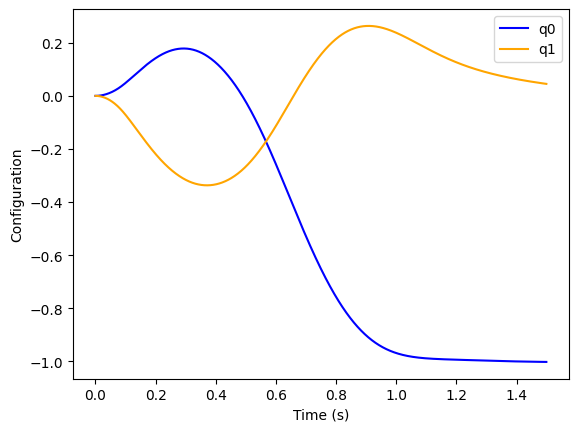

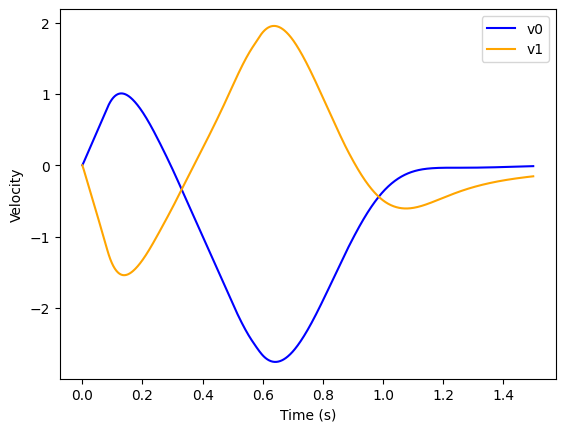

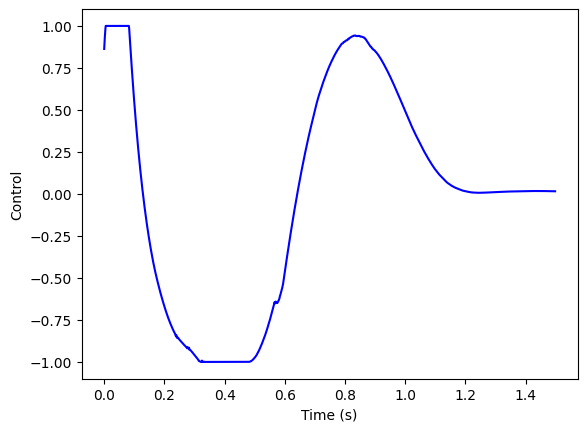

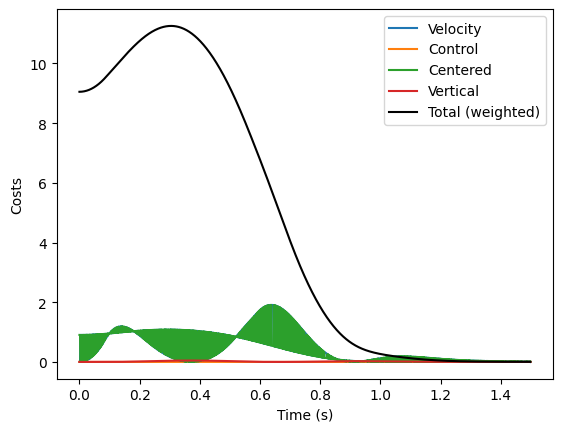

In [8]:

# display video
SLOWDOWN = 0.5
media.show_video(frames, fps=SLOWDOWN * FPS)

# %%
# plot position
fig = plt.figure()

plt.plot(time, qpos[0, :], label="q0", color="blue")
plt.plot(time, qpos[1, :], label="q1", color="orange")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Configuration")

# %%
# plot velocity
fig = plt.figure()

plt.plot(time, qvel[0, :], label="v0", color="blue")
plt.plot(time, qvel[1, :], label="v1", color="orange")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Velocity")

# %%
# plot control
fig = plt.figure()

plt.plot(time[:-1], ctrl[0, :], color="blue")

plt.xlabel("Time (s)")
plt.ylabel("Control")

# %%
# plot costs
fig = plt.figure()

for i, c in enumerate(agent.get_cost_term_values().items()):
  plt.plot(time[:-1], cost_terms[i, :], label=c[0])

plt.plot(time[:-1], cost_total, label="Total (weighted)", color="black")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Costs")
